### **Objective:**

The aim of this project is to define a Speech emption recognition (SER) system that can process and classify speech signals to detect emotions embedded in them. Such a system can find use in a wide variety of application areas like interactive voice based-assistant or caller-agent conversation analysis. In this study an attempt is made to detect underlying emotions in recorded speech by analysing the acoustic features of the audio data of recordings.  

### **Data:**

This project uses Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset. RAVDESS dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

#### **File naming convention:**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics.

#### **Filename identifiers:**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav
1. Audio-only (03)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12)

### **Data Analysis:**

Data analysis involves following steps.
1. Data understanding.
2. Exploratory data analysis.
3. Data augmentation.
4. Feature extraction.
5. Data preprocessing.
6. Model building.

In [1]:
# Import the following libraries.

import pandas as pd
import numpy as np
import glob
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
# Load the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) data.

RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion.

emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

### **Exploratory Data Analysis**

### **Listen to some of the audios with different emotions.**

In [4]:
# Gender: Female, Emotion: Happy 

HF = RAV + 'Actor_08/03-01-03-02-02-01-08.wav'

data, sr = librosa.load(HF)

ipd.Audio(HF) 

In [5]:
# Gender: Female, Emotion: Fear 

FF = RAV +'Actor_08/03-01-06-01-01-01-08.wav'

data, sr = librosa.load(FF)

ipd.Audio(FF) 

In [6]:
# Gender: Female, Emotion: Disgust

FD = RAV +'Actor_20/03-01-07-02-02-02-20.wav'

data, sr = librosa.load(FD)

ipd.Audio(FD) 

In [7]:
# Gender: Male, Emotion: Fearful.

MF = RAV + 'Actor_19/03-01-06-01-02-01-19.wav'

data, sr = librosa.load(MF)

ipd.Audio(MF) 

216
216


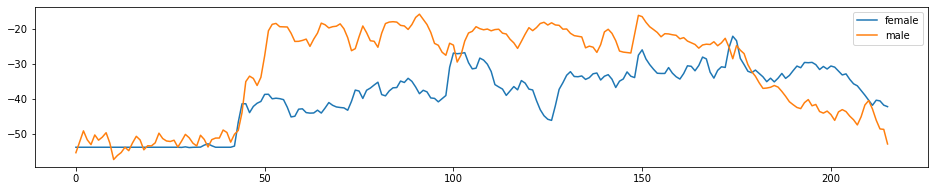

In [8]:
# Comparing pitch of male and female voices.

# Gender: Female, Emotion: angry
path = "../input/ravdess-emotional-speech-audio/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path, res_type = 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)  
female = librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13)
female = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13), axis = 0)
print(len(female))

# Gender: Male, Emotion: angry
path = "../input/ravdess-emotional-speech-audio/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path, res_type = 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)  
male = librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13)
male = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13), axis = 0)
print(len(male))

# Plotting the two audio waves together.

plt.figure(figsize = (16,10))
plt.subplot(3,1,1)
plt.plot(female, label = 'female')
plt.plot(male, label = 'male')
plt.legend()

# Male has a higher pitch.

216
216


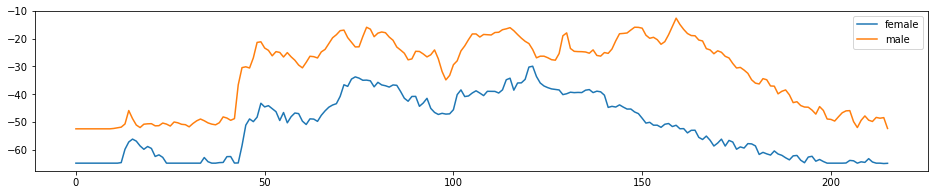

In [9]:
# Comparing pitch of male and female voices.

# Gender: Female, Emotion: Surprised
path = "../input/ravdess-emotional-speech-audio/Actor_20/03-01-08-02-01-02-20.wav"
X, sample_rate = librosa.load(path, res_type = 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)  
female = librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13)
female = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13), axis = 0)
print(len(female))

# Gender: Male, Emotion: Surprised
path = "../input/ravdess-emotional-speech-audio/Actor_21/03-01-08-02-01-01-21.wav"
X, sample_rate = librosa.load(path, res_type = 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)  
male = librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13)
male = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13), axis = 0)
print(len(male))

# Plotting the two audio waves together.

plt.figure(figsize = (16,10))
plt.subplot(3,1,1)
plt.plot(female, label = 'female')
plt.plot(male, label = 'male')
plt.legend()

# Male has a higher pitch.

### **DATA AUGMENTATION:**

* Data augmentation is the process by which we create new polymerized data samples by adding small disturbance on our initial training set.
* To generate polymerized data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those disturbance and enhace its ability to generalize. In order for this to work adding the disturbance must conserve the same label as the original training sample.

In [10]:
# Adding noise to data.

def noise(data, noise_factor):
    
    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added 

    """
    noise = np.random.randn(len(data)) 
    augmented_data = data + noise_factor * noise
    
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [11]:
# Audio with shift.

def shift(data, sampling_rate, shift_max, shift_direction):
    
    """
    shift the spectogram in a direction
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
        
    return augmented_data

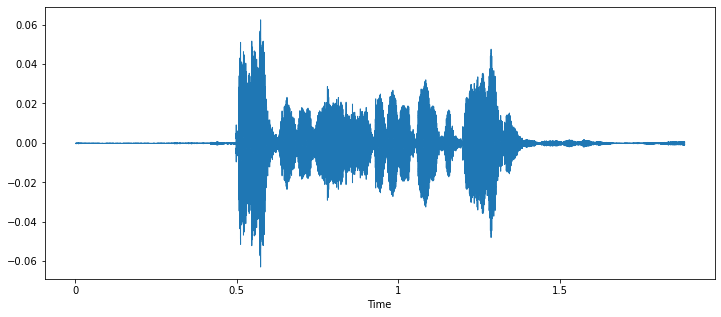

In [12]:
# Normal audio.

import librosa.display

plt.figure(figsize = (12, 5))

librosa.display.waveshow(y = data, sr = sample_rate)

Audio(path)

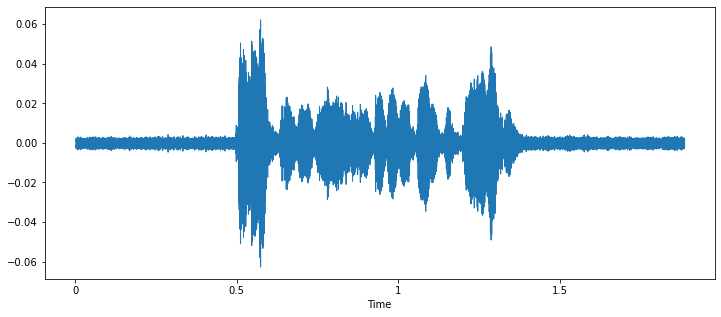

In [13]:
# Audio with noise.

x = noise(data, 0.001)

plt.figure(figsize = (12,5))

librosa.display.waveshow(y = x, sr = sample_rate)

Audio(x, rate = sample_rate)

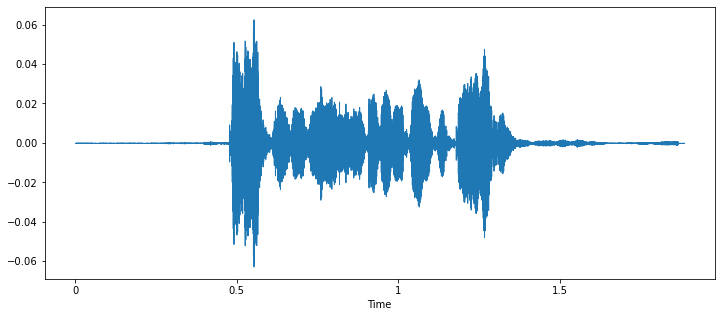

In [14]:
# Shifted audio.

x = shift(data, sr, 0.25, 'right')

plt.figure(figsize = (12,5))

librosa.display.waveshow(y = x, sr = sample_rate)

Audio(x, rate = sample_rate)

### **Feature Extraction**

In [15]:
# Definition to extract features.

def extract_feature(data, sr, mfcc, chroma, mel):
    
    """
    extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y = data, sr = sr, n_mfcc = 40).T, axis = 0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr=sr).T,axis = 0)
        result = np.hstack((result, chroma))
    if mel:                             
        mel = np.mean(librosa.feature.melspectrogram(data, sr = sr).T,axis = 0)
        result = np.hstack((result, mel))
        
    return result 

### **Loading data after data augmentation**

In [16]:
# Definition to load data and simultaniously extract features and apply data augmentation methods.

def load_data(save = False):
    
    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(RAV + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.    
        data, sr = librosa.load(file)
        
        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)
        
        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]  
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)
    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)
        
    return np.array(x), y

In [17]:
# Loading data.

X, y = load_data(save = True)

In [18]:
# Creating train and test split.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 9)

In [19]:
# Encoding the data labels.

labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [20]:
# Get the number of features extracted.

print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


### **Model Building**

### **Decision Tree**

In [21]:
# Building Decision tree classifier.

clf = DecisionTreeClassifier()

clf = clf.fit(x_train,y_train)

In [22]:
# Making predictions on test data.

y_pred = clf.predict(x_test)

print("Accuracy of Decision tree Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))

# Calculating f1_score.

f1_score(y_test,y_pred,average = 'weighted')

Accuracy of Decision tree Classifier: 81.02%


0.8108087173285063

### **Random Forest Classifier**

In [23]:
# Building Random forest classifier.

clf = RandomForestClassifier()

clf = clf.fit(x_train,y_train)

In [24]:
# Making predictions on test data.

y_pred = clf.predict(x_test)

print("Accuracy of Random Forest Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))

# Calculating f1_score.

f1_score(y_test, y_pred, average = 'weighted')

Accuracy of Random Forest Classifier: 93.61%


0.9361615469105761

### **K-Nearest Neighbor classifier**

In [25]:
# Building K-NN model.

clf = KNeighborsClassifier()

clf.fit(x_train,y_train)

KNeighborsClassifier()

In [26]:
# Test the model on test data.

knn_pred = clf.predict(x_test)

print("Accuracy of K-Nearest Neighbor Classifier: {}%".format(round(accuracy_score(y_test, knn_pred)*100,2)))

# Calculating f1_score.

f1_score(y_test, knn_pred, average = 'weighted')                                                                  

Accuracy of K-Nearest Neighbor Classifier: 59.72%


0.5925563556911008

### Support Vector Machine (SVM) model.

In [27]:
# Building SVM model.

clf = SVC(kernel = 'linear')

clf.fit(x_train, y_train)

SVC(kernel='linear')

In [28]:
# Test the model on test data.

svm_pred = clf.predict(x_test)

print("Accuracy of Linear SVM Classifier: {}%".format(round(accuracy_score(y_test, svm_pred)*100,2)))

# Calculating f1_score.

f1_score(y_test, svm_pred, average = 'weighted')                                                                  

Accuracy of Linear SVM Classifier: 62.69%


0.6246932821015903

In [29]:
# Building SVM model with "RBF" kernel.

non_linear_model = SVC(kernel = 'rbf')

non_linear_model.fit(x_train, y_train)

SVC()

In [30]:
# Predicting the test data.

svm_pred = non_linear_model.predict(x_test)

print("Accuracy of SVM Classifier with rbf kernel: {}%".format(round(accuracy_score(y_test, svm_pred)*100,2)))

# Calculating f1_score.

f1_score(y_test, svm_pred, average = 'weighted')                                                                  

Accuracy of SVM Classifier with rbf kernel: 25.65%


0.20740925679488473

### **Multilayer Perceptron (MLP) Classifier**

In [31]:
# Building MLP classifier.

clf = MLPClassifier(alpha = 0.01, batch_size = 270, epsilon = 1e-08, hidden_layer_sizes = (400,), learning_rate = 'adaptive', max_iter = 400, random_state = 100)

clf.fit(x_train, y_train)

MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400, random_state=100)

In [32]:
# Test the model on test data.

MLP_pred = clf.predict(x_test)

print("Accuracy of MLP Classifier: {}%".format(round(accuracy_score(y_test, MLP_pred)*100,2)))

# Calculating f1_score.

f1_score(y_test, MLP_pred, average = 'weighted')                                                                  

Accuracy of MLP Classifier: 72.59%


0.71509304761182

### **Gated Recurrent Unit (GRU) Classifier**

In [33]:
# Reshape for LSTM.

X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)

X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [34]:
# Building GRU model.

model = Sequential()
model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'tanh'))
model.add(Dropout(0.3))
model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'tanh'))
model.add(Dropout(0.3))
model.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1), activation = 'tanh'))
model.add(Dropout(0.3))
model.add(GRU(units = 50, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(units = 14))
model.compile(optimizer = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = False),loss = 'mean_squared_error',metrics = ['accuracy'])

2023-02-07 13:25:35.251851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 13:25:35.252918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 13:25:35.377789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 13:25:35.378691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 13:25:35.379557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [35]:
# Printing model summary.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 180, 50)           7950      
_________________________________________________________________
dropout (Dropout)            (None, 180, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 180, 50)           15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 180, 50)           15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                1

In [36]:
# Fitting the model.

model.fit(X_train, y_train, validation_data = (X_test,y_test),epochs = 100,batch_size = 200)

2023-02-07 13:25:51.595109: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-07 13:25:57.301668: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 10s 114ms/step - loss: 11.5631 - accuracy: 0.1127 - val_loss: 6.1999 - val_accuracy: 0.1194
Epoch 2/100
17/17 [==============================] - 1s 36ms/step - loss: 6.4588 - accuracy: 0.0682 - val_loss: 5.5904 - val_accuracy: 0.1361
Epoch 3/100
17/17 [==============================] - 1s 35ms/step - loss: 5.9161 - accuracy: 0.0806 - val_loss: 5.5271 - val_accuracy: 0.1435
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 5.8414 - accuracy: 0.0744 - val_loss: 5.4933 - val_accuracy: 0.0000e+00
Epoch 5/100
17/17 [==============================] - 1s 35ms/step - loss: 5.7452 - accuracy: 0.0821 - val_loss: 5.4681 - val_accuracy: 0.0620
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 5.6922 - accuracy: 0.0676 - val_loss: 5.4793 - val_accuracy: 0.1250
Epoch 7/100
17/17 [==============================] - 1s 34ms/step - loss: 5.7099 - accuracy: 0.0685 - val_loss: 5.4811 - val_accuracy: 0.1435
Epoch 8/100

In [38]:
# Predicting test data.

y_pred = model.predict(X_test)

print("Accuracy of GRU model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

# Calculating f1_score.

f1_score(y_test,np.argmax(y_pred, axis = -1),average = 'weighted')                                                                

34/34 [==============================] - 0s 11ms/step - loss: 5.4643 - accuracy: 0.1213
Accuracy of GRU model on test data :  12.129629403352737 %


0.02624246872801786

### **Long Short Term Memory (LSTM) model**

In [39]:
# Building LSTM model.

model = Sequential()
model.add(LSTM(70,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(60))
model.add(Dense(14))
model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['accuracy'])

In [40]:
# Printing model summary.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 70)           20160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 50)           24200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                854       
Total params: 71,854
Trainable params: 71,854
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Fitting the model.

model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 100, batch_size = 65, verbose = 1)

Epoch 1/100
50/50 [==============================] - 6s 48ms/step - loss: 9.4665 - accuracy: 0.0917 - val_loss: 5.5040 - val_accuracy: 0.1361
Epoch 2/100
50/50 [==============================] - 1s 24ms/step - loss: 5.4446 - accuracy: 0.0497 - val_loss: 5.4874 - val_accuracy: 0.1398
Epoch 3/100
50/50 [==============================] - 1s 24ms/step - loss: 5.4328 - accuracy: 0.0676 - val_loss: 5.4917 - val_accuracy: 0.0620
Epoch 4/100
50/50 [==============================] - 1s 24ms/step - loss: 5.4317 - accuracy: 0.0559 - val_loss: 5.4788 - val_accuracy: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 1s 24ms/step - loss: 5.4355 - accuracy: 0.0731 - val_loss: 5.4739 - val_accuracy: 0.0000e+00
Epoch 6/100
50/50 [==============================] - 1s 24ms/step - loss: 5.4333 - accuracy: 0.0861 - val_loss: 5.5220 - val_accuracy: 0.1435
Epoch 7/100
50/50 [==============================] - 1s 26ms/step - loss: 5.4410 - accuracy: 0.0892 - val_loss: 5.5073 - val_accuracy: 0.062

In [42]:
# Predicting test data.

y_pred = model.predict(X_test)

print("Accuracy of LSTM model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

# Calculating f1_score.

f1_score(y_test,np.argmax(y_pred,axis = -1),average = 'weighted')

34/34 [==============================] - 0s 9ms/step - loss: 5.4833 - accuracy: 0.1528
Accuracy of LSTM model on test data :  15.27777761220932 %


0.04049531459170013

### **Convolutional Neural Network (CNN)**

In [43]:
# Building CNN model.

model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = Adam(decay=1e-6)

In [44]:
# Compiling the model.

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [45]:
# Reshaping data to fit cnn model.

XProccessed = np.expand_dims(x_train, axis = 2)

XTestProcessed = np.expand_dims(x_test, axis = 2)

In [46]:
# Fitting CNN model.

model.fit(XProccessed, y_train, epochs = 100, validation_data = (XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 [==============================] - 8s 17ms/step - loss: 2.3383 - accuracy: 0.2120 - val_loss: 1.9448 - val_accuracy: 0.2917
Epoch 2/100
51/51 [==============================] - 0s 10ms/step - loss: 1.9198 - accuracy: 0.3102 - val_loss: 1.8719 - val_accuracy: 0.3528
Epoch 3/100
51/51 [==============================] - 1s 10ms/step - loss: 1.7961 - accuracy: 0.3744 - val_loss: 1.7443 - val_accuracy: 0.4120
Epoch 4/100
51/51 [==============================] - 0s 10ms/step - loss: 1.7190 - accuracy: 0.3923 - val_loss: 1.6799 - val_accuracy: 0.4102
Epoch 5/100
51/51 [==============================] - 0s 10ms/step - loss: 1.6517 - accuracy: 0.4370 - val_loss: 1.5907 - val_accuracy: 0.4611
Epoch 6/100
51/51 [==============================] - 0s 10ms/step - loss: 1.5448 - accuracy: 0.4750 - val_loss: 1.5200 - val_accuracy: 0.4907
Epoch 7/100
51/51 [==============================] - 0s 10ms/step - loss: 1.4788 - accuracy: 0.4963 - val_loss: 1.4304 - val_accuracy: 0.5444
Epoch 

In [47]:
# Predicting the test data.

y_pred = model.predict(XTestProcessed)

# Determining accuracy of CNN model.

print("Accuracy of CNN model on test data : " , model.evaluate(XTestProcessed,y_test)[1]*100 , "%")

# Calculating f1_score.

f1_score(y_test, np.argmax(y_pred, axis = -1), average = 'weighted')

34/34 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.8870
Accuracy of CNN model on test data :  88.70370388031006 %


0.8881479395938878

### **Conclusion:**

The following table indicates different models with their Accuracy and F1 score.

| Model | Accuracy (%) | F1 score |
|-------|--------------|----------|
| Decision tree | 81.02 | 0.8108 |
| Random forest | 93.61 | 0.9361 |
| K-nearest neighbor | 59.72 | 0.5925 |
| Support vector machine (Linear kernel) | 62.69 | 0.6249 |
| Support vector machne (RBF kernel ) | 25.65 | 0.2074 |
| Multilayer perceptron (MLP) | 72.59 | 0.7150 |
| Gated recurrent unit (GRU) | 12.12 | 0.0202 |
| Long short term memory (LSTM) | 15.27 | 0.0404 |
| Convolutional neural network (CNN) | 88.70 | 0.8881 |

Out of all the tested models, Random forest performed best with an accuracy of 93.61% and F1 score of 0.9361. Hence Random forest can be used for speech emotion recognition.